Create a ReCom ensemble for partitions of a 10 x 10 grid graph into two districts.  For each plan in the ensemble, keep track of the numbers of spanning trees for each district and the number of cut edges in the plan.  Then plot the relationship between these two quantities.

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import json
%matplotlib inline  
import random
import time
import math
import pickle
import pysal as ps
import libpysal as lib
import os
import csv
from matplotlib.colors import ListedColormap

import pandas as pd
import geopandas as gpd

from gerrychain import Graph, Partition, Election
from gerrychain.updaters import Tally, cut_edges
from gerrychain import MarkovChain
from gerrychain.constraints import single_flip_contiguous
from gerrychain.proposals import propose_random_flip
from gerrychain.accept import always_accept
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.constraints.validity import within_percent_of_ideal_population
from gerrychain.metrics import mean_median,efficiency_gap
from gerrychain.proposals import recom
from functools import partial
from gerrychain.tree import recursive_tree_part
from gerrychain.graph.geo import reprojected


from tqdm import tqdm


In [2]:
# BASIC GRID GRAPH
# n1 = 10  # Graph dimensions
# n2 = 10
# graph1=nx.grid_graph([n1, n2])

In [3]:
# "/Users/FrannyMcWilliams/Jupyter Code/Redistricting/Boulder_18/VTD_08013.shp"

datafile_1 = "/Users/FrannyMcWilliams/Jupyter Code/Redistricting/CO_precincts/co_precincts.shp"
gdf_1 = gpd.read_file(datafile_1)
projected_df_1 = reprojected(gdf_1)
for col in gdf_1.columns:
    print(col)

/opt/anaconda3/lib/python3.8/site-packages/gerrychain/graph/geo.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  utm_counts = Counter(utm_of_point(point) for point in wgs_df["geometry"].centroid)


COUNTYFP
VTDST
NAME
CD116FP
SLDUST
SLDLST
PRECID
AG18D
AG18R
SOS18D
SOS18R
TRE18D
TRE18R
GOV18D
GOV18R
REG18D
REG18R
USH18D
USH18R
TOTPOP
NH_WHITE
NH_BLACK
NH_AMIN
NH_ASIAN
NH_NHPI
NH_OTHER
NH_2MORE
HISP
H_WHITE
H_BLACK
H_AMIN
H_ASIAN
H_NHPI
H_OTHER
H_2MORE
VAP
HVAP
WVAP
BVAP
AMINVAP
ASIANVAP
NHPIVAP
OTHERVAP
2MOREVAP
geometry


In [4]:
centroids_1 = gdf_1.centroid
c_x_1 = centroids_1.x
c_y_1 = centroids_1.y

rW_1 = lib.weights.Rook.from_dataframe(gdf_1)

graph_1 = nx.Graph(rW_1.neighbors)

ctds = {x:(c_x_1[int(x)],c_y_1[int(x)]) for x in rW_1.neighbors.keys()}

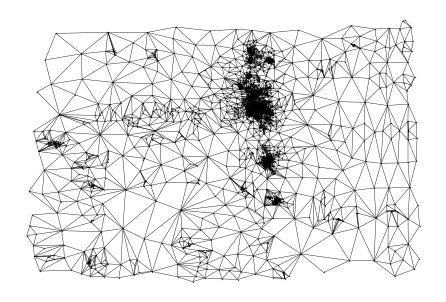

In [5]:
# BASIC VERSION
# plt.figure()
# nx.draw(graph1, pos = {x:x for x in graph1.nodes()}, node_size = 50, node_shape ='s')
# plt.show()

plt.figure()
nx.draw(graph_1, pos=ctds, node_size=.1, node_color='k', width=.4)
plt.show()

Set each graph node's population equal to 1 and identify which nodes are on the outer boundary of the graph:

In [6]:
districtr_colors = [
    "#0099cd","#ffca5d","#00cd99","#99cd00","#cd0099","#9900cd",
    "#8dd3c7","#bebada","#fb8072","#80b1d3","#fdb462","#b3de69",
    "#fccde5","#bc80bd","#ccebc5","#ffed6f","#ffffb3","#a6cee3",
    "#1f78b4","#b2df8a","#33a02c","#fb9a99","#e31a1c","#fdbf6f",
    "#ff7f00","#cab2d6","#6a3d9a","#b15928","#64ffda","#00B8D4",
    "#A1887F","#76FF03","#DCE775","#B388FF","#FF80AB","#D81B60",
    "#26A69A","#FFEA00","#6200EA"
]

def districtr_cmap(number_of_colors=len(districtr_colors)):
    return ListedColormap(districtr_colors[:number_of_colors])

mycolormap_1 = districtr_cmap(25)

In [7]:
precinct_list_1 = gdf_1["VTDST"].tolist()

numcolors = len(mycolormap_1.colors)

# Initialize my color dictionary by assigning every precinct the number -1:
mycolorindexmap_1 = {precinct_list_1[i]: -1  for i in range(len(precinct_list_1))}

# Start with the first color in the color list:
currcolor = 0

# This loop cycles through the precincts, creates a list of all the current color values 
# for all the neighboring precincts, and checks whether the current color is in this list.
# If not, then assign the current color to the precinct.  If it is, move to the next color
# on the list (mod numcolors) and check again.

for i in range(len(precinct_list_1)):
    neighborcolors = [mycolorindexmap_1[precinct_list_1[j]] for j in rW_1.neighbors[i]]
    while currcolor in neighborcolors:
        currcolor = (currcolor+1)%numcolors  # cycle through the color list
    mycolorindexmap_1[precinct_list_1[i]] = currcolor

gdf_1["colorcode"] = gdf_1["VTDST"].map(mycolorindexmap_1)

In [8]:
# BASIC VERSION
# for n in graph1.nodes():
#     graph1.nodes[n]["population"]=1

#     if 0 == n[0] or n2-1 == n[0] or 0 == n[1] or n1-1 == n[1]:
#         graph1.nodes[n]["boundary_node"]=True
#         if (0 == n[0] or n2-1 == n[0]) and (0 == n[1] or n1-1 == n[1]):
#             graph1.nodes[n]["boundary_perim"]=2
#         else:
#             graph1.nodes[n]["boundary_perim"]=1
#     else:
#         graph1.nodes[n]["boundary_node"]=False

Build a simple initial partition into 2 districts. 

In [9]:
#  BASIC VERSION
# number_of_district = 4

# cddict={}
# count=0
# for n in graph1.nodes(): 
#   cddict[n]=int(count/(n1*n2/number_of_district))
#   count=count+1
    
  
# print(cddict[(2,7)])
# cddict = {x: int(5*x[0]/n2)  for x in graph1.nodes()}    

Plot initial partition, just for kicks:

In [10]:
# BASIC VERSION
# plt.figure()
# nx.draw(graph1, pos = {x:x for x in graph1.nodes()}, node_color = [cddict[x] for x in graph1.nodes()] ,node_size = 50, node_shape ='s',cmap = 'tab20')
# plt.show()

<Figure size 432x288 with 0 Axes>

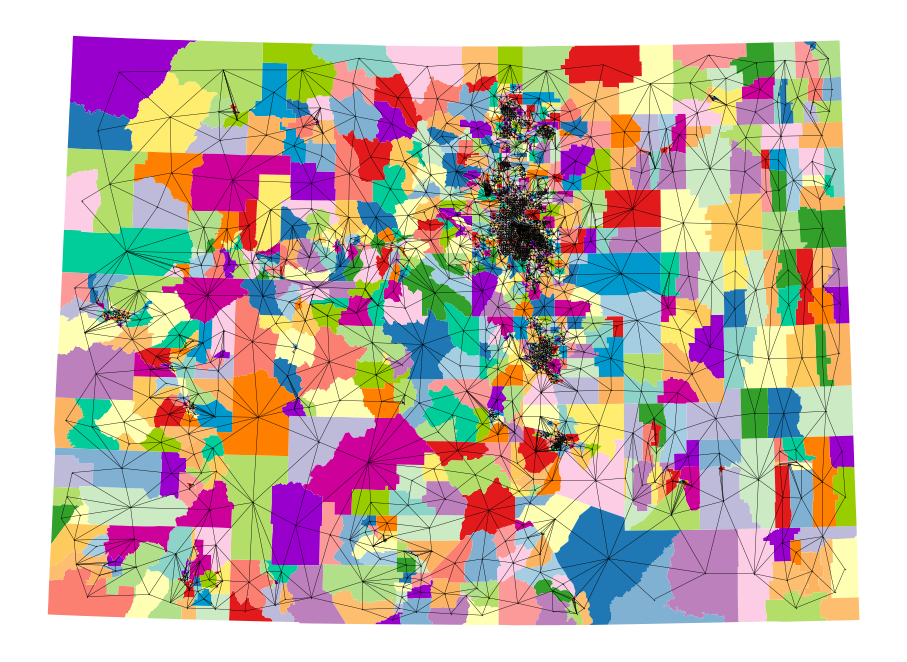

,COUNTYFP,VTDST,NAME,CD116FP,SLDUST,SLDLST,PRECID,AG18D,AG18R,SOS18D,SOS18R,TRE18D,TRE18R,GOV18D,GOV18R,REG18D,REG18R,USH18D,USH18R,TOTPOP,NH_WHITE,NH_BLACK,NH_AMIN,NH_ASIAN,NH_NHPI,NH_OTHER,NH_2MORE,HISP,H_WHITE,H_BLACK,H_AMIN,H_ASIAN,H_NHPI,H_OTHER,H_2MORE,VAP,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,geometry
0,005,005230,Arapahoe 230,01,031,009,1310903230,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((508234.924 4386190.022, 508246.088 4..."
1,005,005256,Arapahoe 256,06,026,003,2147483647,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((512663.103 4386046.307, 512694.687 4..."
2,005,005359,Arapahoe 359,04,029,056,2147483647,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((532402.077 4393729.843, 532403.119 4..."
3,005,005561,Arapahoe 561,06,028,036,2147483647,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((521125.938 4392491.967, 521702.039 4..."
4,031,031745,Denver 745,01,033,007,1330716745,1084,303,1073,316,1046,334,1137,272,1050,254,1121,264,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((511474.738 4404493.245, 511440.417 4..."


In [11]:
# Create the graph
plt.figure()
gdf_1.plot(column="colorcode", cmap=mycolormap_1, figsize=(16,20))
plt.axis('off')
nx.draw(graph_1,pos=ctds,node_size=.1,node_color='k',edge_color='k',width=.4)
plt.show()

# Display columns
df = gpd.read_file(datafile_1)
pd.set_option('display.max_columns', None)
df.head()

In [12]:
global unique_label 
unique_label = "NAME"  #Unique identifier for the voting district
global population_col
population_col = "fakepop"
global district_col
district_col = "COUNTYFP" #Change for: state house (SLDLST) or house sentate district (SLDUST) or congressional (CD116FP)
global county_col
county_col = "COUNTYFP"

election_names = ["GOV", "AG", "SEC", "TRE", "REG"]

election_columns = [
    ["GOV_DEM18", "GOV_REP18"],
    ["AG_DEM18","AG_REP18"],
    ["SEC_DEM18","SEC_REP18"],
    ["TRE_DEM18","TRE_REP18"],
    ["REG_DEM18","REG_REP18"]
]
num_elections = len(election_names)
num_districts = 4
elections = [
    Election(
        election_names[i],
        {"Democratic": election_columns[i][0], "Republican": election_columns[i][1]},
    )
    for i in range(num_elections)
]

updaters = {"population": Tally("fakepop", alias="population"),
            "cut_edges": cut_edges}

gdf_1["fakepop"] = 1
graph_1 = Graph.from_geodataframe(gdf_1)
graph_1.add_data(gdf_1, columns=["fakepop"])

election_updaters = {election.name: election for election in elections}

updaters.update(election_updaters)

Define and configure updaters and a function to count number of spanning trees:

3135


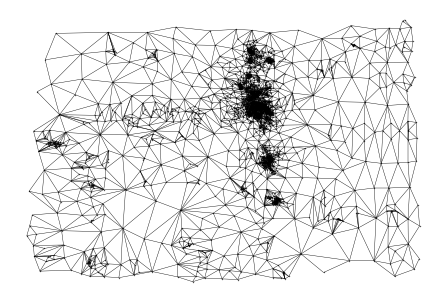

In [13]:
total_pop = gdf_1.fakepop.sum() #add up all entries from total pop
ideal_pop_CD = int(total_pop/4)

seeds_CD = recursive_tree_part(graph_1, range(4), ideal_pop_CD, population_col, .005, 1)

seed=dict(seeds_CD)
enacted_plan = GeographicPartition(graph_1, assignment=seed, updaters=updaters)

print(total_pop)
count=0

number_of_district=num_districts

plt.figure()
nx.draw(graph_1,pos=ctds,node_size=.1,node_color='k',edge_color='k',width=.4)
plt.show()

In [14]:
def number_spanning_trees(graph):
    laplacian = nx.laplacian_matrix(graph, weight = None).toarray()
    minor_matrix = laplacian[1:,1:]
    return int(np.linalg.slogdet(minor_matrix)[1]+0.5)
    
    # return int(np.exp(np.linalg.slogdet(minor_matrix)[1])+0.5)
    # return int(np.linalg.det(minor_matrix) + 0.5)

In [15]:
initial_partition = Partition(graph_1,assignment=seeds_CD,updaters=updaters)


Add constraints:

In [16]:
popbound=within_percent_of_ideal_population(initial_partition,.02)


Set up the ReCom proposal and define the chain:

In [17]:
tree_proposal = partial(recom,pop_col="fakepop",pop_target=ideal_pop_CD,epsilon=0.4,node_repeats=1)

recom_chain=MarkovChain(
    proposal=tree_proposal,
    constraints=[
        constraints.within_percent_of_ideal_population(initial_partition, .4)
            ],
        accept=accept.always_accept,
        initial_state=initial_partition,
        total_steps=1000
        )

Define lists to keep track of statistics for each chain:

In [18]:
number_cut_edges = []
number_spanning_list = []

Run chain, draw final districting plan in the chain, and collect stats

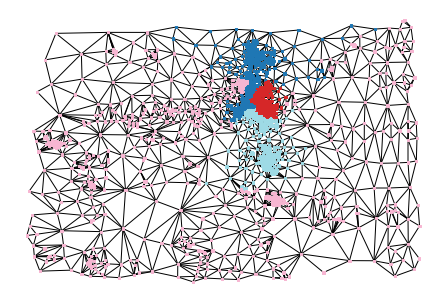

In [19]:
for partition in recom_chain.with_progress_bar():
    number_spanning = 1
    for dist_num, subgraph in partition.subgraphs.items():
        number_spanning *= number_spanning_trees(subgraph)
    number_cut_edges.append(len(cut_edges(partition)))
    number_spanning_list.append(math.log(number_spanning))

plt.figure()
nx.draw(graph_1, pos = ctds, node_color = [dict(partition.assignment)[x] for x in graph_1.nodes()] ,node_size = 5, node_shape ='s',cmap = 'tab20')
plt.show()


Relationship between product of numbers of spanning trees (plotted on a log scale) for each district and cut edges for the plan:

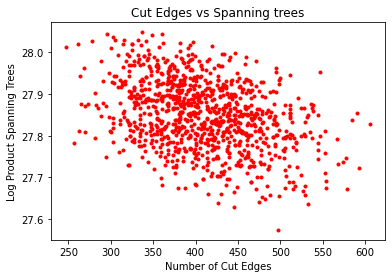

In [20]:
plt.plot(number_cut_edges, number_spanning_list, 'r.')
plt.xlabel("Number of Cut Edges")
plt.ylabel("Log Product Spanning Trees")
plt.title("Cut Edges vs Spanning trees")
plt.show()
